In [1]:

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

#import tensorflow as tf
import os

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [2]:
!pip install tensorflow


# Importing necessary libaries

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Read the data

In [4]:
df=pd.read_csv("AMZN BP DATA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
1,02-04-2014,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2,03-04-2014,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
3,04-04-2014,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
4,07-04-2014,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2204 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


# Data Preprocessing

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df.set_index('Date',inplace=True)

In [9]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
2014-02-04,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2014-03-04,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
2014-04-04,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
2014-07-04,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


# Missing entries


In [10]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [11]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [12]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [13]:
all_datetimes.shape

(3283,)

# Supplying missing values

## Insert missing datetimes

In [14]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [15]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2204 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 230.8 KB


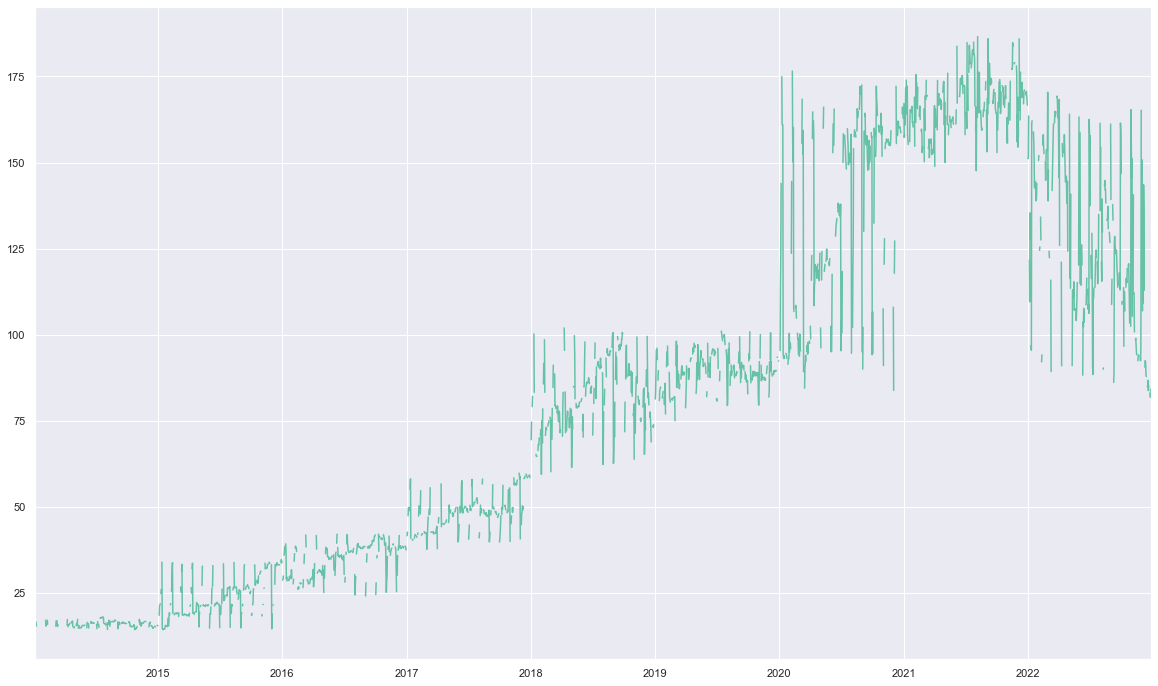

In [16]:
plot = df['Close'].plot(figsize=(20, 12))

In [17]:
df["Close"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df["Open"]=df["Open"].ffill()
df["High"]=df["High"].ffill()
df["Low"]=df["Low"].ffill()
df["Volume"]=df["Volume"].ffill()
df["Change"]=df["Change"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
2014-01-04,16.904499,17.2215,16.900000,17.149500,72002000.0,3.0,NaN,3658.399902
2014-01-05,15.206500,15.5240,15.200000,15.394500,86572000.0,5.0,0.188000,3594.360107
2014-01-06,15.206500,15.5240,15.200000,15.394500,86572000.0,NaN,0.188000,3594.360107
2014-01-07,16.292999,16.6600,16.254999,16.619499,63472000.0,3.0,0.380499,3894.330078
2014-01-08,15.684500,15.7915,15.229500,15.353000,148830000.0,6.0,-0.296500,3879.669922
2014-01-09,15.684500,15.7915,15.229500,15.353000,148830000.0,NaN,-0.296500,3879.669922
2014-01-10,16.101999,16.1085,15.777500,15.873000,61782000.0,4.0,-0.249000,3984.739990
2014-01-11,16.101999,16.1085,15.777500,15.873000,61782000.0,NaN,-0.249000,3984.739990
2014-01-12,16.906000,17.0320,16.296499,16.299999,98898000.0,2.0,-0.632000,4287.810059
2014-01-13,16.906000,17.0320,16.296499,16.299999,98898000.0,NaN,-0.632000,4287.810059


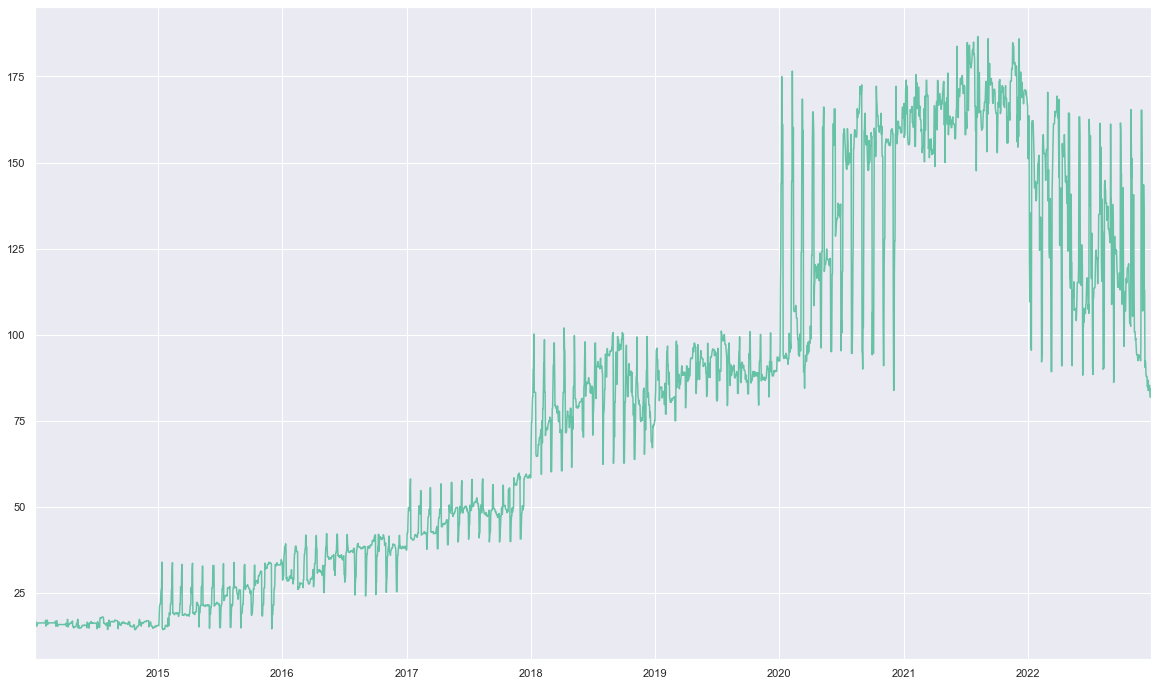

In [18]:
plot = df[ "Close"].plot(figsize=(20, 12))

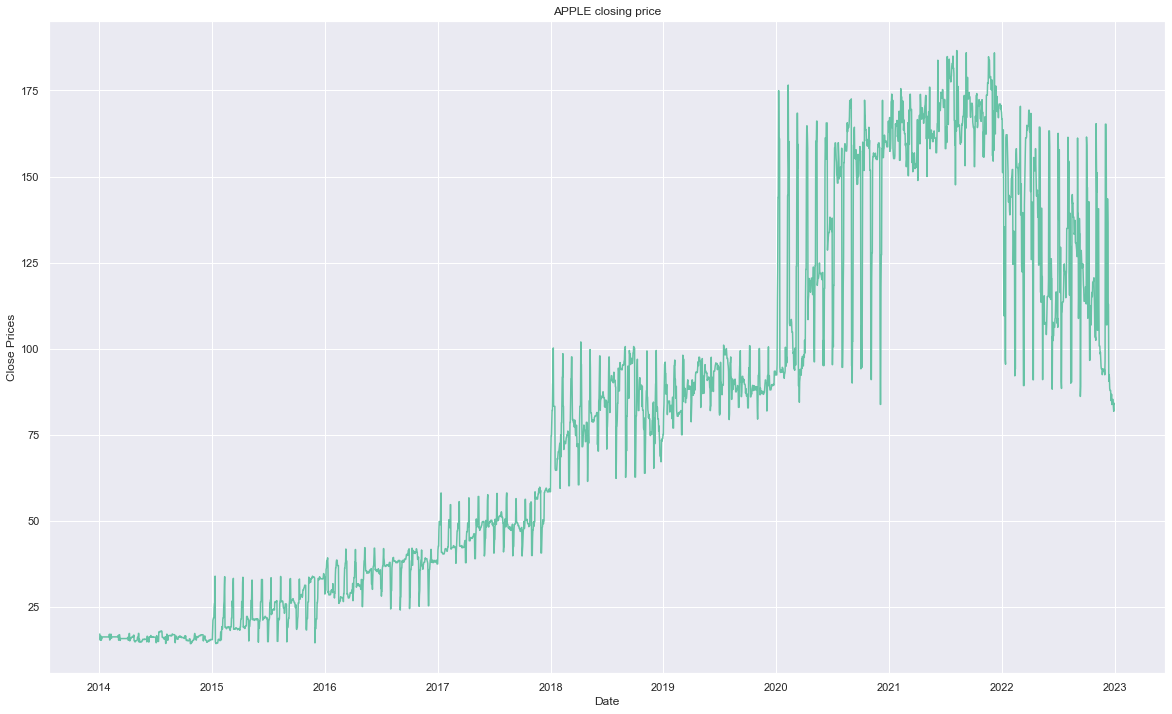

In [19]:
#plot close price
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('APPLE closing price')
plt.show()

In [20]:
df=df["Close"]
df

2014-01-04    17.149500
2014-01-05    15.394500
2014-01-06    15.394500
2014-01-07    16.619499
2014-01-08    15.353000
                ...    
2022-12-26    85.250000
2022-12-27    83.040001
2022-12-28    81.820000
2022-12-29    84.180000
2022-12-30    84.000000
Name: Close, Length: 3283, dtype: float64

<AxesSubplot:>

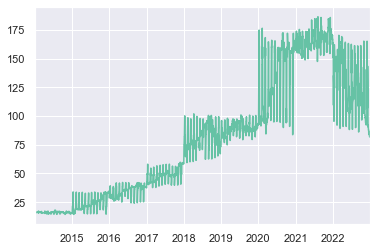

In [21]:
df.plot()

# Build model

In [22]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [23]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df, WINDOW_SIZE)
X1.shape, y1.shape

((3278, 5, 1), (3278,))

# Train test split

In [24]:
X_train1, y_train1 = X1[:2922], y1[:2922]
X_test1, y_test1 = X1[2922:], y1[2922:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((2922, 5, 1), (2922,), (356, 5, 1), (356,))

In [25]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [27]:
model1.fit(X_train1, y_train1, epochs=100, callbacks=[cp1])

Epoch 1/100
83/92 [==========================>...] - ETA: 0s - loss: 8278.1660 - root_mean_squared_error: 90.9844

92/92 [==============================] - 2s 5ms/step - loss: 8274.8066 - root_mean_squared_error: 90.9660
Epoch 2/100
87/92 [===========================>..] - ETA: 0s - loss: 8207.8350 - root_mean_squared_error: 90.5971

92/92 [==============================] - 0s 5ms/step - loss: 8182.9233 - root_mean_squared_error: 90.4595
Epoch 3/100
85/92 [==========================>...] - ETA: 0s - loss: 8074.4619 - root_mean_squared_error: 89.8580

92/92 [==============================] - 0s 4ms/step - loss: 8076.4805 - root_mean_squared_error: 89.8692
Epoch 4/100
86/92 [===========================>..] - ETA: 0s - loss: 7932.0195 - root_mean_squared_error: 89.0619

92/92 [==============================] - 0s 4ms/step - loss: 7919.1597 - root_mean_squared_error: 88.9897
Epoch 5/100
91/92 [============================>.] - ETA: 0s - loss: 7736.7241 - root_mean_squared_error: 87.9586

92/92 [==============================] - 0s 4ms/step - loss: 7746.3799 - root_mean_squared_error: 88.0135
Epoch 6/100
92/92 [==============================] - ETA: 0s - loss: 7448.4717 - root_mean_squared_error: 86.3045

92/92 [==============================] - 0s 3ms/step - loss: 7448.4717 - root_mean_squared_error: 86.3045
Epoch 7/100
85/92 [==========================>...] - ETA: 0s - loss: 7019.6904 - root_mean_squared_error: 83.7836

92/92 [==============================] - 0s 3ms/step - loss: 6991.8550 - root_mean_squared_error: 83.6173
Epoch 8/100
75/92 [=======================>......] - ETA: 0s - loss: 6675.7832 - root_mean_squared_error: 81.7055

92/92 [==============================] - 0s 3ms/step - loss: 6620.8008 - root_mean_squared_error: 81.3683
Epoch 9/100
81/92 [=========================>....] - ETA: 0s - loss: 6504.0117 - root_mean_squared_error: 80.6475

92/92 [==============================] - 0s 3ms/step - loss: 6390.0918 - root_mean_squared_error: 79.9380
Epoch 10/100
90/92 [============================>.] - ETA: 0s - loss: 6185.0889 - root_mean_squared_error: 78.6453

92/92 [==============================] - 0s 4ms/step - loss: 6181.3047 - root_mean_squared_error: 78.6213
Epoch 11/100
82/92 [=========================>....] - ETA: 0s - loss: 6001.6143 - root_mean_squared_error: 77.4701

92/92 [==============================] - 0s 3ms/step - loss: 5956.1328 - root_mean_squared_error: 77.1760
Epoch 12/100
90/92 [============================>.] - ETA: 0s - loss: 5736.4688 - root_mean_squared_error: 75.7395

92/92 [==============================] - 0s 3ms/step - loss: 5718.3984 - root_mean_squared_error: 75.6201
Epoch 13/100
89/92 [============================>.] - ETA: 0s - loss: 5536.9976 - root_mean_squared_error: 74.4110

92/92 [==============================] - 0s 3ms/step - loss: 5528.9399 - root_mean_squared_error: 74.3568
Epoch 14/100
89/92 [============================>.] - ETA: 0s - loss: 5375.9756 - root_mean_squared_error: 73.3210

92/92 [==============================] - 0s 2ms/step - loss: 5348.2598 - root_mean_squared_error: 73.1318
Epoch 15/100
88/92 [===========================>..] - ETA: 0s - loss: 5217.0815 - root_mean_squared_error: 72.2294

92/92 [==============================] - 0s 4ms/step - loss: 5177.8823 - root_mean_squared_error: 71.9575
Epoch 16/100
80/92 [=========================>....] - ETA: 0s - loss: 4983.4531 - root_mean_squared_error: 70.5936

92/92 [==============================] - 0s 3ms/step - loss: 5013.7031 - root_mean_squared_error: 70.8075
Epoch 17/100
92/92 [==============================] - ETA: 0s - loss: 4850.5117 - root_mean_squared_error: 69.6456

92/92 [==============================] - 0s 3ms/step - loss: 4850.5117 - root_mean_squared_error: 69.6456
Epoch 18/100
87/92 [===========================>..] - ETA: 0s - loss: 4702.7783 - root_mean_squared_error: 68.5768

92/92 [==============================] - 0s 4ms/step - loss: 4691.3394 - root_mean_squared_error: 68.4934
Epoch 19/100
92/92 [==============================] - ETA: 0s - loss: 4535.0713 - root_mean_squared_error: 67.3429

92/92 [==============================] - 0s 3ms/step - loss: 4535.0713 - root_mean_squared_error: 67.3429
Epoch 20/100
87/92 [===========================>..] - ETA: 0s - loss: 4404.8169 - root_mean_squared_error: 66.3688

92/92 [==============================] - 0s 5ms/step - loss: 4382.3164 - root_mean_squared_error: 66.1991
Epoch 21/100
89/92 [============================>.] - ETA: 0s - loss: 4206.4785 - root_mean_squared_error: 64.8574

92/92 [==============================] - 1s 6ms/step - loss: 4232.6719 - root_mean_squared_error: 65.0590
Epoch 22/100
80/92 [=========================>....] - ETA: 0s - loss: 4109.6787 - root_mean_squared_error: 64.1068

92/92 [==============================] - 0s 5ms/step - loss: 4085.9265 - root_mean_squared_error: 63.9213
Epoch 23/100
85/92 [==========================>...] - ETA: 0s - loss: 3969.2346 - root_mean_squared_error: 63.0019

92/92 [==============================] - 0s 4ms/step - loss: 3942.5996 - root_mean_squared_error: 62.7901
Epoch 24/100
92/92 [==============================] - ETA: 0s - loss: 3801.9917 - root_mean_squared_error: 61.6603

92/92 [==============================] - 0s 4ms/step - loss: 3801.9917 - root_mean_squared_error: 61.6603
Epoch 25/100
88/92 [===========================>..] - ETA: 0s - loss: 3698.7197 - root_mean_squared_error: 60.8171

92/92 [==============================] - 0s 4ms/step - loss: 3664.1465 - root_mean_squared_error: 60.5322
Epoch 26/100
83/92 [==========================>...] - ETA: 0s - loss: 3517.2505 - root_mean_squared_error: 59.3064

92/92 [==============================] - 0s 4ms/step - loss: 3529.1536 - root_mean_squared_error: 59.4067
Epoch 27/100
90/92 [============================>.] - ETA: 0s - loss: 3397.0667 - root_mean_squared_error: 58.2844

92/92 [==============================] - 0s 4ms/step - loss: 3397.1394 - root_mean_squared_error: 58.2850
Epoch 28/100
81/92 [=========================>....] - ETA: 0s - loss: 3309.6470 - root_mean_squared_error: 57.5295

92/92 [==============================] - 0s 4ms/step - loss: 3267.5896 - root_mean_squared_error: 57.1628
Epoch 29/100
85/92 [==========================>...] - ETA: 0s - loss: 3112.2488 - root_mean_squared_error: 55.7875

92/92 [==============================] - 0s 5ms/step - loss: 3132.9128 - root_mean_squared_error: 55.9724
Epoch 30/100
88/92 [===========================>..] - ETA: 0s - loss: 2992.8662 - root_mean_squared_error: 54.7071

92/92 [==============================] - 0s 5ms/step - loss: 2997.3201 - root_mean_squared_error: 54.7478
Epoch 31/100
91/92 [============================>.] - ETA: 0s - loss: 2859.8657 - root_mean_squared_error: 53.4777

92/92 [==============================] - 0s 5ms/step - loss: 2873.2974 - root_mean_squared_error: 53.6031
Epoch 32/100
76/92 [=======================>......] - ETA: 0s - loss: 2763.9570 - root_mean_squared_error: 52.5733

92/92 [==============================] - 0s 5ms/step - loss: 2752.6267 - root_mean_squared_error: 52.4655
Epoch 33/100
86/92 [===========================>..] - ETA: 0s - loss: 2599.3193 - root_mean_squared_error: 50.9835

92/92 [==============================] - 0s 4ms/step - loss: 2636.2561 - root_mean_squared_error: 51.3445
Epoch 34/100
82/92 [=========================>....] - ETA: 0s - loss: 2552.6353 - root_mean_squared_error: 50.5236

92/92 [==============================] - 0s 5ms/step - loss: 2523.1345 - root_mean_squared_error: 50.2308
Epoch 35/100
91/92 [============================>.] - ETA: 0s - loss: 2415.0149 - root_mean_squared_error: 49.1428

92/92 [==============================] - 0s 5ms/step - loss: 2412.7646 - root_mean_squared_error: 49.1199
Epoch 36/100
92/92 [==============================] - ETA: 0s - loss: 2306.0186 - root_mean_squared_error: 48.0210

92/92 [==============================] - 0s 4ms/step - loss: 2306.0186 - root_mean_squared_error: 48.0210
Epoch 37/100
90/92 [============================>.] - ETA: 0s - loss: 2188.3586 - root_mean_squared_error: 46.7799

92/92 [==============================] - 0s 4ms/step - loss: 2202.4822 - root_mean_squared_error: 46.9306
Epoch 38/100
85/92 [==========================>...] - ETA: 0s - loss: 2085.2761 - root_mean_squared_error: 45.6648

92/92 [==============================] - 0s 5ms/step - loss: 2102.1587 - root_mean_squared_error: 45.8493
Epoch 39/100
90/92 [============================>.] - ETA: 0s - loss: 2017.2755 - root_mean_squared_error: 44.9141

92/92 [==============================] - 0s 5ms/step - loss: 2005.3713 - root_mean_squared_error: 44.7814
Epoch 40/100
84/92 [==========================>...] - ETA: 0s - loss: 1902.4045 - root_mean_squared_error: 43.6166

92/92 [==============================] - 0s 5ms/step - loss: 1912.4426 - root_mean_squared_error: 43.7315
Epoch 41/100
85/92 [==========================>...] - ETA: 0s - loss: 1836.7773 - root_mean_squared_error: 42.8576

92/92 [==============================] - 0s 5ms/step - loss: 1823.3843 - root_mean_squared_error: 42.7011
Epoch 42/100
92/92 [==============================] - ETA: 0s - loss: 1737.6768 - root_mean_squared_error: 41.6855

92/92 [==============================] - 0s 4ms/step - loss: 1737.6768 - root_mean_squared_error: 41.6855
Epoch 43/100
85/92 [==========================>...] - ETA: 0s - loss: 1637.5458 - root_mean_squared_error: 40.4666

92/92 [==============================] - 0s 4ms/step - loss: 1655.5486 - root_mean_squared_error: 40.6884
Epoch 44/100
80/92 [=========================>....] - ETA: 0s - loss: 1628.6305 - root_mean_squared_error: 40.3563

92/92 [==============================] - 0s 5ms/step - loss: 1576.9314 - root_mean_squared_error: 39.7106
Epoch 45/100
90/92 [============================>.] - ETA: 0s - loss: 1491.0858 - root_mean_squared_error: 38.6146

92/92 [==============================] - 1s 6ms/step - loss: 1501.4541 - root_mean_squared_error: 38.7486
Epoch 46/100
83/92 [==========================>...] - ETA: 0s - loss: 1463.2654 - root_mean_squared_error: 38.2527

92/92 [==============================] - 0s 4ms/step - loss: 1430.1759 - root_mean_squared_error: 37.8177
Epoch 47/100
92/92 [==============================] - ETA: 0s - loss: 1361.1730 - root_mean_squared_error: 36.8941

92/92 [==============================] - 0s 4ms/step - loss: 1361.1730 - root_mean_squared_error: 36.8941
Epoch 48/100
88/92 [===========================>..] - ETA: 0s - loss: 1300.5962 - root_mean_squared_error: 36.0638

92/92 [==============================] - 0s 5ms/step - loss: 1296.1830 - root_mean_squared_error: 36.0025
Epoch 49/100
88/92 [===========================>..] - ETA: 0s - loss: 1235.1248 - root_mean_squared_error: 35.1443

92/92 [==============================] - 0s 4ms/step - loss: 1234.1835 - root_mean_squared_error: 35.1309
Epoch 50/100
90/92 [============================>.] - ETA: 0s - loss: 1181.4907 - root_mean_squared_error: 34.3728

92/92 [==============================] - 0s 4ms/step - loss: 1174.9285 - root_mean_squared_error: 34.2772
Epoch 51/100
88/92 [===========================>..] - ETA: 0s - loss: 1111.7560 - root_mean_squared_error: 33.3430

92/92 [==============================] - 0s 4ms/step - loss: 1117.8486 - root_mean_squared_error: 33.4342
Epoch 52/100
90/92 [============================>.] - ETA: 0s - loss: 1063.4518 - root_mean_squared_error: 32.6106

92/92 [==============================] - 0s 4ms/step - loss: 1063.3053 - root_mean_squared_error: 32.6084
Epoch 53/100
88/92 [===========================>..] - ETA: 0s - loss: 1009.8463 - root_mean_squared_error: 31.7781

92/92 [==============================] - 0s 4ms/step - loss: 1010.7556 - root_mean_squared_error: 31.7924
Epoch 54/100
87/92 [===========================>..] - ETA: 0s - loss: 956.4756 - root_mean_squared_error: 30.9269

92/92 [==============================] - 0s 5ms/step - loss: 959.6263 - root_mean_squared_error: 30.9778
Epoch 55/100
92/92 [==============================] - ETA: 0s - loss: 909.8956 - root_mean_squared_error: 30.1645

92/92 [==============================] - 0s 4ms/step - loss: 909.8956 - root_mean_squared_error: 30.1645
Epoch 56/100
83/92 [==========================>...] - ETA: 0s - loss: 877.4526 - root_mean_squared_error: 29.6218

92/92 [==============================] - 0s 4ms/step - loss: 861.6333 - root_mean_squared_error: 29.3536
Epoch 57/100
89/92 [============================>.] - ETA: 0s - loss: 809.9604 - root_mean_squared_error: 28.4598

92/92 [==============================] - 0s 3ms/step - loss: 815.0403 - root_mean_squared_error: 28.5489
Epoch 58/100
86/92 [===========================>..] - ETA: 0s - loss: 776.6622 - root_mean_squared_error: 27.8687

92/92 [==============================] - 0s 5ms/step - loss: 769.2589 - root_mean_squared_error: 27.7355
Epoch 59/100
85/92 [==========================>...] - ETA: 0s - loss: 724.9490 - root_mean_squared_error: 26.9249

92/92 [==============================] - 0s 4ms/step - loss: 724.9699 - root_mean_squared_error: 26.9253
Epoch 60/100
90/92 [============================>.] - ETA: 0s - loss: 684.3993 - root_mean_squared_error: 26.1610

92/92 [==============================] - 0s 3ms/step - loss: 682.2687 - root_mean_squared_error: 26.1203
Epoch 61/100
89/92 [============================>.] - ETA: 0s - loss: 636.6138 - root_mean_squared_error: 25.2312

92/92 [==============================] - 0s 2ms/step - loss: 640.8928 - root_mean_squared_error: 25.3159
Epoch 62/100
86/92 [===========================>..] - ETA: 0s - loss: 611.3124 - root_mean_squared_error: 24.7247

92/92 [==============================] - 0s 2ms/step - loss: 601.0372 - root_mean_squared_error: 24.5161
Epoch 63/100
73/92 [======================>.......] - ETA: 0s - loss: 571.0627 - root_mean_squared_error: 23.8969

92/92 [==============================] - 0s 2ms/step - loss: 562.8302 - root_mean_squared_error: 23.7240
Epoch 64/100
70/92 [=====================>........] - ETA: 0s - loss: 537.4673 - root_mean_squared_error: 23.1833

92/92 [==============================] - 0s 2ms/step - loss: 526.2522 - root_mean_squared_error: 22.9402
Epoch 65/100
71/92 [======================>.......] - ETA: 0s - loss: 526.4743 - root_mean_squared_error: 22.9450

92/92 [==============================] - 0s 2ms/step - loss: 490.9194 - root_mean_squared_error: 22.1567
Epoch 66/100
82/92 [=========================>....] - ETA: 0s - loss: 459.1671 - root_mean_squared_error: 21.4282

92/92 [==============================] - 0s 2ms/step - loss: 457.3483 - root_mean_squared_error: 21.3857
Epoch 67/100
92/92 [==============================] - ETA: 0s - loss: 425.3785 - root_mean_squared_error: 20.6247

92/92 [==============================] - 0s 3ms/step - loss: 425.3785 - root_mean_squared_error: 20.6247
Epoch 68/100
82/92 [=========================>....] - ETA: 0s - loss: 398.7791 - root_mean_squared_error: 19.9695

92/92 [==============================] - 0s 4ms/step - loss: 395.0200 - root_mean_squared_error: 19.8751
Epoch 69/100
82/92 [=========================>....] - ETA: 0s - loss: 366.6017 - root_mean_squared_error: 19.1468

92/92 [==============================] - 0s 3ms/step - loss: 365.8888 - root_mean_squared_error: 19.1282
Epoch 70/100
85/92 [==========================>...] - ETA: 0s - loss: 337.2234 - root_mean_squared_error: 18.3636

92/92 [==============================] - 0s 3ms/step - loss: 338.3274 - root_mean_squared_error: 18.3937
Epoch 71/100
77/92 [========================>.....] - ETA: 0s - loss: 312.2569 - root_mean_squared_error: 17.6708

92/92 [==============================] - 0s 3ms/step - loss: 312.0655 - root_mean_squared_error: 17.6654
Epoch 72/100
83/92 [==========================>...] - ETA: 0s - loss: 287.1173 - root_mean_squared_error: 16.9445

92/92 [==============================] - 0s 4ms/step - loss: 287.8181 - root_mean_squared_error: 16.9652
Epoch 73/100
80/92 [=========================>....] - ETA: 0s - loss: 265.0984 - root_mean_squared_error: 16.2818

92/92 [==============================] - 0s 3ms/step - loss: 264.9651 - root_mean_squared_error: 16.2777
Epoch 74/100
75/92 [=======================>......] - ETA: 0s - loss: 232.3348 - root_mean_squared_error: 15.2425

92/92 [==============================] - 0s 3ms/step - loss: 243.4433 - root_mean_squared_error: 15.6027
Epoch 75/100
91/92 [============================>.] - ETA: 0s - loss: 222.6989 - root_mean_squared_error: 14.9231

92/92 [==============================] - 0s 4ms/step - loss: 223.3082 - root_mean_squared_error: 14.9435
Epoch 76/100
92/92 [==============================] - ETA: 0s - loss: 204.4511 - root_mean_squared_error: 14.2986

92/92 [==============================] - 0s 3ms/step - loss: 204.4511 - root_mean_squared_error: 14.2986
Epoch 77/100
87/92 [===========================>..] - ETA: 0s - loss: 189.5706 - root_mean_squared_error: 13.7685

92/92 [==============================] - 0s 5ms/step - loss: 187.5502 - root_mean_squared_error: 13.6949
Epoch 78/100
88/92 [===========================>..] - ETA: 0s - loss: 173.2719 - root_mean_squared_error: 13.1633

92/92 [==============================] - 0s 5ms/step - loss: 171.4505 - root_mean_squared_error: 13.0939
Epoch 79/100
86/92 [===========================>..] - ETA: 0s - loss: 155.8218 - root_mean_squared_error: 12.4829

92/92 [==============================] - 0s 4ms/step - loss: 156.7674 - root_mean_squared_error: 12.5207
Epoch 80/100
86/92 [===========================>..] - ETA: 0s - loss: 142.3821 - root_mean_squared_error: 11.9324

92/92 [==============================] - 0s 3ms/step - loss: 143.3486 - root_mean_squared_error: 11.9728
Epoch 81/100
84/92 [==========================>...] - ETA: 0s - loss: 127.6928 - root_mean_squared_error: 11.3001

92/92 [==============================] - 0s 2ms/step - loss: 131.0140 - root_mean_squared_error: 11.4461
Epoch 82/100
91/92 [============================>.] - ETA: 0s - loss: 119.4401 - root_mean_squared_error: 10.9289

92/92 [==============================] - 0s 2ms/step - loss: 119.8859 - root_mean_squared_error: 10.9492
Epoch 83/100
72/92 [======================>.......] - ETA: 0s - loss: 111.9477 - root_mean_squared_error: 10.5805

92/92 [==============================] - 0s 2ms/step - loss: 109.9705 - root_mean_squared_error: 10.4867
Epoch 84/100
73/92 [======================>.......] - ETA: 0s - loss: 100.3289 - root_mean_squared_error: 10.0164

92/92 [==============================] - 0s 2ms/step - loss: 101.0462 - root_mean_squared_error: 10.0522
Epoch 85/100
72/92 [======================>.......] - ETA: 0s - loss: 94.2884 - root_mean_squared_error: 9.7102

92/92 [==============================] - 0s 2ms/step - loss: 93.2234 - root_mean_squared_error: 9.6552
Epoch 86/100
73/92 [======================>.......] - ETA: 0s - loss: 86.0967 - root_mean_squared_error: 9.2788

92/92 [==============================] - 0s 2ms/step - loss: 85.9354 - root_mean_squared_error: 9.2701
Epoch 87/100
90/92 [============================>.] - ETA: 0s - loss: 79.5056 - root_mean_squared_error: 8.9166

92/92 [==============================] - 0s 2ms/step - loss: 79.5687 - root_mean_squared_error: 8.9201
Epoch 88/100
91/92 [============================>.] - ETA: 0s - loss: 73.6695 - root_mean_squared_error: 8.5831

92/92 [==============================] - 0s 4ms/step - loss: 74.1430 - root_mean_squared_error: 8.6106
Epoch 89/100
77/92 [========================>.....] - ETA: 0s - loss: 69.2641 - root_mean_squared_error: 8.3225

92/92 [==============================] - 0s 3ms/step - loss: 69.2049 - root_mean_squared_error: 8.3189
Epoch 90/100
78/92 [========================>.....] - ETA: 0s - loss: 61.8845 - root_mean_squared_error: 7.8667

92/92 [==============================] - 0s 3ms/step - loss: 64.8403 - root_mean_squared_error: 8.0523
Epoch 91/100
89/92 [============================>.] - ETA: 0s - loss: 61.2696 - root_mean_squared_error: 7.8275

92/92 [==============================] - 0s 3ms/step - loss: 61.1509 - root_mean_squared_error: 7.8199
Epoch 92/100
83/92 [==========================>...] - ETA: 0s - loss: 58.4268 - root_mean_squared_error: 7.6437

92/92 [==============================] - 0s 5ms/step - loss: 57.9727 - root_mean_squared_error: 7.6140
Epoch 93/100
85/92 [==========================>...] - ETA: 0s - loss: 52.6947 - root_mean_squared_error: 7.2591

92/92 [==============================] - 0s 4ms/step - loss: 55.4669 - root_mean_squared_error: 7.4476
Epoch 94/100
90/92 [============================>.] - ETA: 0s - loss: 53.4790 - root_mean_squared_error: 7.3129

92/92 [==============================] - 0s 5ms/step - loss: 52.9366 - root_mean_squared_error: 7.2758
Epoch 95/100
91/92 [============================>.] - ETA: 0s - loss: 51.0177 - root_mean_squared_error: 7.1427

92/92 [==============================] - 0s 4ms/step - loss: 50.8753 - root_mean_squared_error: 7.1327
Epoch 96/100
88/92 [===========================>..] - ETA: 0s - loss: 49.2718 - root_mean_squared_error: 7.0194

92/92 [==============================] - 0s 5ms/step - loss: 49.2697 - root_mean_squared_error: 7.0192
Epoch 97/100
89/92 [============================>.] - ETA: 0s - loss: 48.2629 - root_mean_squared_error: 6.9472

92/92 [==============================] - 0s 4ms/step - loss: 47.8646 - root_mean_squared_error: 6.9184
Epoch 98/100
91/92 [============================>.] - ETA: 0s - loss: 46.6536 - root_mean_squared_error: 6.8303

92/92 [==============================] - 0s 4ms/step - loss: 46.6103 - root_mean_squared_error: 6.8272
Epoch 99/100
88/92 [===========================>..] - ETA: 0s - loss: 45.6422 - root_mean_squared_error: 6.7559

92/92 [==============================] - 0s 5ms/step - loss: 45.5045 - root_mean_squared_error: 6.7457
Epoch 100/100
89/92 [============================>.] - ETA: 0s - loss: 44.3367 - root_mean_squared_error: 6.6586

92/92 [==============================] - 0s 5ms/step - loss: 44.5794 - root_mean_squared_error: 6.6768


In [28]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

92/92 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,15.435945,15.353000
1,15.357088,15.873000
2,15.846387,15.873000
3,15.860070,16.299999
4,16.239948,16.299999
...,...,...
2917,155.503357,163.559998
2918,158.805450,163.559998
2919,159.739655,121.683998
2920,129.004700,109.559998


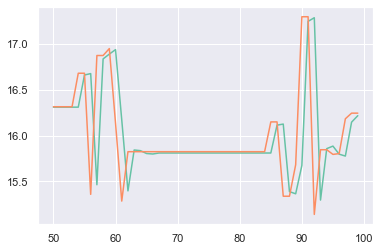

In [29]:

plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [35]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

12/12 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,139.223663,127.820000
1,132.027588,127.820000
2,128.393219,96.790001
3,98.015038,95.500000
4,97.947701,161.214005
...,...,...
351,85.070953,85.250000
352,85.062973,83.040001
353,83.059509,81.820000
354,82.058350,84.180000


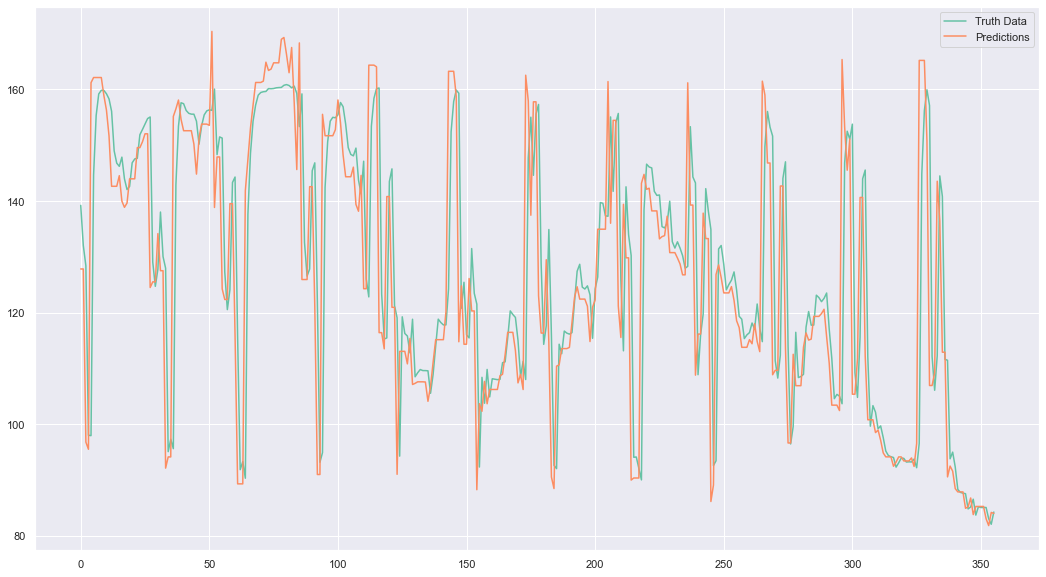

In [36]:
plt.figure(figsize=(18,10))

plt.plot(test_results['Test Predictions'][:356])
plt.plot(test_results['Actuals'][:356])
plt.legend(['Truth Data', 'Predictions'])

# Evaluating forecast results

In [32]:
score = np.sqrt(mean_squared_error(test_results['Test Predictions'], test_results['Actuals']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 15.54


In [33]:
# report performance
mse = mean_squared_error(test_predictions, y_test1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_predictions, y_test1)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_predictions, y_test1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_test1 - test_predictions)/np.abs(test_predictions))
print('MAPE: '+str(mape))

MSE: 241.620387157065
MAE: 8.995545153052856
RMSE: 15.54414317860798
MAPE: 0.07214443310717071


In [34]:
get_mda(y_test1,test_predictions)

0.3436619718309859